## HW06

Some exercises with images

### Import helpers

Run the following 2 cells to import helper functions, files and libraries

In [1]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py

In [2]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py

In [3]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py

In [4]:
!wget -qO- https://github.com/DM-GY-9103-2024F-H/9103-utils/releases/latest/download/lfw.tar.gz | tar xz

In [5]:
! pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [6]:
import pandas as pd
import torch

from sklearn.model_selection import train_test_split


from data_utils import PCA, RandomForestClassifier, StandardScaler, SVC
from data_utils import classification_error, display_confusion_matrix
from data_utils import LFWUtils

In [7]:
from os import listdir, path
from random import choice

from image_utils import open_image, make_image, edges
from HW06_utils import HW06Utils
from data_utils import classification_error, display_confusion_matrix
from os import listdir, path
from sklearn.model_selection import train_test_split
from torch import nn, Tensor
from torch.utils.data import DataLoader

from data_utils import PCA, StandardScaler
from data_utils import classification_error, display_confusion_matrix
from data_utils import LFWUtils

from image_utils import make_image, open_image

### Review

We can use the `open_image()` function to open image files. 

Then we can use the `size` variable to get their size and the `getbands()` function to get the number of channels.

The built-in jupyter function `display()` draws our image on the notebook.

In [ ]:
mimg = open_image("./data/images/secret_01.png")

image_width, image_height = mimg.size

print(image_width, "x", image_height)
print("total number of pixels:", image_width * image_height)
print("number of channels:", len(mimg.getbands()))

display(mimg)

### Getting pixel color lists

The `pixels` member variable on `Image` objects holds a list of pixel color values that we can iterate over.

In [ ]:
mpxs = mimg.pixels

print(len(mpxs))
print(mpxs[0])

Ok, now for the actual homework...

## Pixel Manipulation

Let's open `./data/images/secret_00.png` again using these methods and take a closer look at the image.

In [ ]:
mimg01 = open_image("./data/images/secret_01.png")
mpxs01 = mimg01.pixels

print(len(mpxs01))
print(mpxs01[0])

display(mimg01)

### Exercise 06

Since we have to change the aspect ratio of the image, we can't use `update_pixels()` anymore.

We have to use `make_image(pxs, width, height)` with correct values for the `width` and `height` parameters.

Let's start by checking the dimensions of this image and doing some math to see how to make it a square.

##### Reminder:

The `width` and `height` of a square image are equal. So:

$number\ of\ pixels = width\ \times height\\
\textcolor{transparent}{number\ of\ pixels} = width\ \times width\\
\textcolor{transparent}{number\ of\ pixels} = height \times height$

$\sqrt{x}$ is the same thing as $x^{0.5}$, and in python we can do that with: `x ** 0.5`.

In [ ]:
mpxs06[0]


In [ ]:
# Work on exercise 06

# current dimensions
img_width, img_height = mimg06.size

total_pixels = len(mpxs06)

new_width = int(total_pixels**0.5)
new_height = int(total_pixels**0.5)


### Check Exercise 06

Run this cell to see the fixed image.

In [ ]:
fixed_img = make_image(mpxs06, new_width, new_height)
display(fixed_img)

## Image Classification

I messed up again and now I have a directory full of image files with erroneous filenames.

# 😓

The `data/images/classification/test` directory has a bunch of files that I want to separate according to what's on the picture. I could do this by hand, but since there are more than $150$ files, I'd rather not.

Luckily, some files were exported with correct names. Those are in the `data/images/classification/train` directory.

The files are either of `forests`, `trees`, or flower arrangements done by `florists`.

Our task for this exercise is to take a look at the correctly labeled files in the `train` directory, do some analysis on their pixels, and see if there are any patterns or properties that we could use to automatically re-label the files in the `test` directory.

Let's break this down into steps again.

### 01A. Reading all the labeled files

Let's first read all of the files in the `data/images/classification/train` directory.

We are going to use the `Python` system function `listdir()` for listing files in a directory.

In [13]:
# Declare location of train files
TRAIN_PATH = "data/images/pokemon_train"

# List comprehension for getting all of the filenames that end in "jpg" inside the train directory
train_files = [f for f in listdir(TRAIN_PATH) if f.endswith("png")]

### Checking our list

Take a look at the `train_files` list.

How many files are there?

How are the file names formatted ?

In [ ]:
# print the size of the train_files list here, along with some of its contents
print(len(train_files))
train_files[0]

### 01B. Reading the unlabeled files

Repeat the above steps to get the names of all of the files inside the `data/images/classification/test` directory.

How many files are there?

How are the files named?

Print the number of files in the directory and their names below.

In [14]:
# Fill out the values for these two variables

# Declare location of test files
TEST_PATH = "data/images/pokemon_test"

# Get all of the filenames that end in "jpg" inside the test directory
test_files = [f for f in listdir(TEST_PATH) if f.endswith("png")]

# Print the number of files inside the list and some of its contents
print(len(test_files))
test_files[0]

4


'yanma_gen.png'

### 02A. Iterating through the files

Let's iterate through all of the files in `train_files`, open them, and get the number of pixels for each image.

In order to analyze, plot and process our data later, let's keep track of the number of pixels and the name of the file in a list with the following format:

```py
file_info = [
  [value, filename],
  [value, filename],
  ...
]
```

This is exactly like how we organized data in the last homework assignment: `file_info` is a list of lists, where each inner list has two members, `value`, which is some numeric info about the image, and `filename`, which is the name of the file.

For now, the `value` we are interested in extracting is the number of pixels in each image file.

We'll use the `Python` function `path.join()` to get the full path of the files inside our `train_files` list.

And then, just like in the previous homework, we can use the `plot_labels_vals()` function inside the `HW06Utils` class to plot the info we extract from our files.

We just have to call the function with a list of `[value, filename]` elements, and a title for our graph.

If the `filename` used contains information about the image label it will group values by those labels.


In [ ]:
# list to keep info about image files
length_info_train = []

# iterate through all of the filenames inside the train files list
for fname in train_files:
  # this gets us the full location path for the filename
  fpath = path.join(TRAIN_PATH, fname)

  # open the file and read its pixels into an array
  mimg = open_image(fpath)
  mpxs = mimg.pixels

  # get value of interest (number of pixels in image)
  val = len(mpxs)

  # store the info using the format specified above
  length_info_train.append([ val, fname ])

# check that we processed all files. This should be as long as the train_files list
print(len(length_info_train))

# plot the (val, filename) pairs
HW06Utils.plot_labels_vals(length_info_train, "Train file pixel counts")

# 🤔

The values on the x-axis are the number of pixels in each file.

We can see that the images all have different sizes, but they're all around $50000$ pixels, and it doesn't look like pixel count is a feature we could use to classify our images.

But, let's make sure there are no patterns.

### 02B. Repeat for `test` files

Repeat the above process for the test files.

In [ ]:
import matplotlib.pyplot as plt

# list to keep info about image files
length_info_test = []

for fname_test in test_files:
  # this gets us the full location path for the filename
  fpath_test = path.join(TEST_PATH, fname_test)

  # open the file and read its pixels into an array
  mimg_test = open_image(fpath_test)
  mpxs_test = mimg_test.pixels

  # get value of interest (number of pixels in image)
  val_test = len(mpxs_test)

  # store the info using the format specified above
  length_info_test.append([ val_test, fname_test ])

# check that we processed all files. This should be as long as the train_files list
print(len(length_info_test))

# plot the (val, filename) pairs
HW06Utils.plot_labels_vals(length_info_test, "Test file pixel counts")

We can see that there are some image sizes that are more common, but it doesn't look like pixel count will tell us anything about the content of the image.

Either way, it's always a good idea to plot any and all information about our data because sometimes we get lucky and find some pattern that is easy to extract and use.

### 03. Looking at other data

Let's repeat the process of extracting info from our files, but this time let's look at the image's color information.

We saw many ways of counting pixel colors in the [WK06 notebook](https://github.com/DM-GY-9103-2024F-H/WK06): channel histograms, channel separation, channel average value, filtering etc. We could try out a few of these different techniques, but filtering and counting might be the easiest method for extracting info about colors that are in multiple channels.

Just like we extracted the yellow flowers from the hedgehog image, let's start by filtering and counting the purple pixels. If an image has purple pixels, it's probably a `florist` picture. There's even an [html color](https://www.w3schools.com/colors/colors_names.asp) called [Orchid](https://www.w3schools.com/colors/color_tryit.asp?color=MediumOrchid) that we can try.

The `color_ratio()` function from our [WK06 notebook](https://github.com/DM-GY-9103-2024F-H/WK06) is available inside the `HW06Utils` class, and we can just use it here by calling:

```py
pixel_ratio = HW06Utils.color_ratio(img, color, thold)
```

It takes an image, a color and a threshold value as inputs, and returns the ratio of detected pixels of that color relative to the total number of pixels in the image.

We want to use relative pixel counts or ratios to avoid any kind of bias due to image sizes. If we used absolute count, small areas of purple pixels in large images might overshadow large areas of purple pixels in smaller images.

In [ ]:
# list to keep info about image files
image_info_train = []

# color to filter: Orchid
keep_color = (186, 85, 211)

# iterate through all of the filenames inside the train files list
for fname in train_files:
  # this gets us the full location path for the filename
  fpath = path.join(TRAIN_PATH, fname)

  # open the file and read its pixels into an array
  mimg = open_image(fpath)

  # get value of interest (purple pixel ratio)
  val = HW06Utils.color_ratio(mimg, keep_color, 180)

  # store the info using the format specified above
  image_info_train.append([ val, fname ])

# check that we processed all files. This should be as long as the train_files list
print(len(image_info_train))

HW06Utils.plot_labels_vals(image_info_train, "Train: purple ratio")

# 🤨

There's something of a pattern here.

As expected, the `florist` images tend to have more `purple` than the other images, and surprisingly, `tree` images seem to have more purple than the `forest` images.

Let's build a model for classifying our images based on purple pixel ratio.

### 04. Create a model

Let's use the info in the graph and create a function that outputs the image label based on its purple pixel amount.

If the purple ratio of an image is greater than $0.8$ we'll say it's a `florist` image, if it's between $0.4$ and $0.8$ we'll label it `tree`, otherwise it's a `forest`.

It won't be perfect, but we can check how close we get with just this small amount of information.

In [ ]:
# function that takes an image and returns a label
def purple_ratio_classifier(img):
  keep_color = (186, 85, 211)
  purple_ratio = HW06Utils.color_ratio(img, keep_color, 180)
  if purple_ratio > 0.6:
    return "generated"
  else:
    return "original"

### Random classifier

We're also gonna create a random classifier to use as a baseline for comparisons later.

The random classifier just guesses a label randomly. Our model should do better than random guesses.

In [ ]:
# random classifier to use for comparisons
def random_classifier(_):
  # the choice() function selects a random element from a list
  return choice(["generated","original" ])

### 05. Run classification on `train` data

Let's iterate through all the train files again, and this time instead of saving the purple ratio value and the filename in the list, we'll save our calculated label and the filename.

```py
purple_ratio_predictions = [
  [label, filename],
  [label, filename],
  ...
]
```

We'll also keep track of classifications made by the `random_classifier`.

In [ ]:
# list to keep info about predictions
purple_ratio_predictions_train = []

# list to keep info about random predictions
random_predictions_train = []

# iterate through all of the filenames inside the train files list
for fname in train_files:
  # this gets us the full location path for the filename
  fpath = path.join(TRAIN_PATH, fname)

  # open the image from the file
  mimg = open_image(fpath)

  # get prediction using model defined above
  prediction = purple_ratio_classifier(mimg)

  # get prediction using random classifier defined above
  random_prediction = random_classifier(mimg)

  # store the prediction and filename
  purple_ratio_predictions_train.append([ prediction, fname ])

  # store the random prediction and filename
  random_predictions_train.append([ random_prediction, fname ])

# check that we processed all files. This should be as long as the train_files list
print(len(purple_ratio_predictions_train))

# look at first couple of predictions just to check that our format is correct
print(purple_ratio_predictions_train[:3])

### 06. Check accuracy on `train` data

We could go through the list and extract the correct label information from the filename to check our predictions, but luckily our `HW06Utils` class has a function that does that.

We just have to call `classification_accuracy()` with our list of labels and filenames.

We can also call it with the random predictions to see how we compare to randomly guessing labels.

### if the name have the gen then give it the label 0 vice versa

In [ ]:
print("Purple Classifier", HW06Utils.classification_accuracy(purple_ratio_predictions_train))
#print("Random Classifier", HW06Utils.classification_accuracy(random_predictions_train))

Not bad. Our model predicts the correct label about half of the time, which is better than randomly guessing and getting it right $33\%$ of the time.

Let's see how it performs on the actual `test` data.

### 07. Run model on `test` data and check accuracy

Repeat the above, but using the `test` data files.

Don't worry about keeping track of random classifications this time. We know they're correct about $33\%$ of the time.

In [ ]:
# list to keep info about predictions
purple_ratio_predictions_test = []

for fname in test_files:
  # this gets us the full location path for the filename
  fpath = path.join(TEST_PATH, fname)

  # open the image from the file
  mimg = open_image(fpath)

  # get prediction using model defined above
  prediction = purple_ratio_classifier(mimg)

  # store the prediction and filename
  purple_ratio_predictions_test.append([ prediction, fname ])

# check that we processed all files. This should be as long as the train_files list
print(len(purple_ratio_predictions_test))

# look at first couple of predictions just to check that our format is correct
print(purple_ratio_predictions_test[:3])

#print("Purple Classifier", HW06Utils.classification_accuracy(purple_ratio_predictions_test))

## Random Forest

### Helper Function

In [10]:
# helper function to add lable
def add_label(fname):
    # Initialize the label
    if 'gen' in fname:  # Check if 'gen' is in the filename
        label = 1  # Assign 1 if 'gen' is found
    else:
        label = 0  # Assign 0 otherwise
    return label  # Return the label


In [ ]:
import pandas as pd
import numpy as np


def classification_accuracy(train_files, train_predictions):

    # Ensure train_predictions is a DataFrame with exactly one column
    if not isinstance(train_predictions, pd.DataFrame) or train_predictions.shape[1] != 1:
        raise ValueError("train_predictions must be a DataFrame with a single column.")
    
    # Extract predictions as a flat list/array
    predictions = train_predictions.iloc[:, 0].tolist()

    # Check if train_files and predictions have the same length
    if len(train_files) != len(predictions):
        raise ValueError("The length of train_files and train_predictions must match.")

    # Generate true labels from the filenames
    true_labels = [1 if 'gen' in fname else 0 for fname in train_files]

    # Compare predictions with true labels
    correct_predictions = sum([pred == true for pred, true in zip(predictions, true_labels)])

    # Calculate accuracy as a percentage
    accuracy = (correct_predictions / len(train_files)) * 100

    return accuracy


In [12]:
# Group every 4 elements into sublists within the array
def group_pixels(pixel_array, group_size=4):
    grouped_pixels = np.array(pixel_array).reshape(-1, group_size)
    return grouped_pixels

In [16]:
def train_test_split(data, test_ratio=0.2, random_seed=None):

    # Set the random seed for reproducibility (optional)
    if random_seed is not None:
        np.random.seed(random_seed)

    # Convert to a NumPy array for easier manipulation if it's a list
    if isinstance(data, list):
        data = np.array(data)

    # Shuffle the indices of the data
    indices = np.arange(len(data))
    np.random.shuffle(indices)

    # Compute the split point
    split_point = int(len(data) * (1 - test_ratio))

    # Split the data into training and testing sets
    train_indices = indices[:split_point]
    test_indices = indices[split_point:]

    if isinstance(data, pd.DataFrame):  # For DataFrame input
        train_data = data.iloc[train_indices]
        test_data = data.iloc[test_indices]
    else:  # For lists or NumPy arrays
        train_data = data[train_indices]
        test_data = data[test_indices]

    return train_data, test_data

### Train Dataset

### Template for black and white image

In [30]:
pixel_data = []
label_data = []

for fname in train_files:
  label = add_label(fname)
  img = open_image(path.join("./data/images/pokemon_train", fname))
  pixel_data.append(img.pixels)
  label_data.append(label)

In [31]:
pixel_data[0]

[(173, 173, 173, 255),
 (172, 172, 172, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (169, 169, 169, 255),
 (169, 169, 169, 255),
 (171, 171, 171, 255),
 (171, 171, 171, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (170, 170, 170, 255),
 (171, 171, 171, 255),
 (170, 170, 170, 255),
 (170, 170,

### Color Images

In [11]:
import numpy as np

In [15]:
pixel_data = []
label_data = []

for fname in train_files:
  label = add_label(fname)
  img = open_image(path.join("./data/images/pokemon_train", fname))
 # Convert the pixel data to a NumPy array
  pixel_array = np.array(img.pixels)
    
    # Flatten the NumPy array
  flattened_pixels = pixel_array.flatten()
    
  pixel_data.append(flattened_pixels)
  label_data.append(label)

In [16]:
pixel_data[0]

array([173, 173, 173, ..., 171, 171, 255])

### Show Color Image

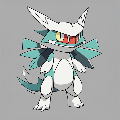

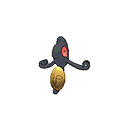

In [17]:

# Group the pixel data for display
image_0 = group_pixels(pixel_data[0], group_size=4)
image_10 = group_pixels(pixel_data[10], group_size=4)

# Display the grouped pixel data
display(make_image(image_0, width=120))
display(make_image(image_10, width=120))


### Make Pixels into DataFrame

In [18]:
train_df = pd.DataFrame(pixel_data)
train_df["label"] = label_data

In [19]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,57591,57592,57593,57594,57595,57596,57597,57598,57599,label
0,173,173,173,255,172,172,172,255,171,171,...,255,172,172,172,255,171,171,171,255,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,211,213,214,255,210,212,213,255,210,211,...,255,209,210,212,255,209,210,212,255,1
4,186,186,186,255,185,185,185,255,185,185,...,255,185,185,185,255,185,185,185,255,1


### For Test

In [20]:
test_pixel_data = []

# Flatten pixel data for each image
for fname in test_files:
    img = open_image(path.join("./data/images/pokemon_test", fname))
    # Flatten the image pixels into a 1D array
    flattened_pixels = np.array(img.pixels).flatten()
    test_pixel_data.append(flattened_pixels)

# Load into DataFrame
test_df = pd.DataFrame(test_pixel_data)

In [21]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,57590,57591,57592,57593,57594,57595,57596,57597,57598,57599
0,218,218,218,255,218,218,218,255,216,216,...,215,255,213,215,215,255,213,215,215,255
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,214,214,214,255,214,214,214,255,214,214,...,213,255,213,213,213,255,213,213,213,255
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Random Forest Classifier Model

In [22]:
# split input and output features
NUM_FEATURES = 5
chosen_columns = train_df.columns[:NUM_FEATURES]
train_features = train_df[chosen_columns]

out_features = train_df["label"]

# also separate test dataset features
test_features = test_df[chosen_columns]

In [23]:
out_features

0     1
1     0
2     0
3     1
4     1
5     1
6     1
7     0
8     0
9     1
10    0
11    1
12    0
13    0
14    0
15    1
Name: label, dtype: int64

In [24]:
train_features

,0,1,2,3,4
0,173,173,173,255,172
1,0,0,0,0,0
2,0,0,0,0,0
3,211,213,214,255,210
4,186,186,186,255,185
5,218,218,218,255,217
6,212,214,213,255,209
7,0,0,0,0,0
8,0,0,0,0,0
9,218,218,218,255,217


In [25]:
# TODO: create a brand new classifier
image_model = RandomForestClassifier()
# TODO: fit the model
image_model.fit(train_features, out_features)
# TODO: run predictions
train_predictions = image_model.predict(train_features)

In [26]:
classification_accuracy(train_files, train_predictions)

100.0

In [ ]:
type(train_predictions)

pandas.core.frame.DataFrame

In [27]:
# TODO: run predictions on test data
test_predictions = image_model.predict(test_features)
# TODO: measure classification accuracy
classification_accuracy(test_files, test_predictions)

100.0

### PCA from HW10

### try also using random forest and other classification

In [8]:
TRAIN_GEN_PATH = "data/images/pokemon_generated"

# Get all of the filenames that end in "jpg" inside the test directory
train_gen_files = [f for f in listdir(TRAIN_GEN_PATH) if f.endswith("png")]

In [15]:
# Lists to store the data
pixel_data = []
label_data = []
file_names = []

for fname in train_gen_files:
    # Get the label for the image
    label = add_label(fname)
    
    # Load the image
    img = open_image(path.join("./data/images/pokemon_generated", fname))
    
    # Convert the pixel data to a NumPy array and flatten it
    pixel_array = np.array(img.pixels).flatten()
    
    # Append the data to the respective lists
    pixel_data.append(pixel_array.tolist())  # Convert flattened NumPy array to list
    label_data.append(label)
    file_names.append(fname)

# Create the DataFrame with three columns
train_gen_df = pd.DataFrame({
    "pixels": pixel_data,
    "label": label_data,
    "fname": file_names
})

# Display the first few rows of the DataFrame
print(train_gen_df.head())


                                              pixels  label            fname
0  [191, 191, 191, 255, 191, 191, 191, 255, 191, ...      1     new1_gen.png
1  [173, 173, 173, 255, 172, 172, 172, 255, 171, ...      1  yanmega_gen.png
2  [214, 214, 214, 255, 213, 213, 213, 255, 213, ...      1     new2_gen.png
3  [218, 218, 218, 255, 218, 218, 218, 255, 216, ...      1    yanma_gen.png
4  [67, 65, 64, 255, 66, 65, 63, 255, 64, 62, 62,...      1     new8_gen.png


In [20]:
train, test = train_test_split(train_gen_df,0.5 )

In [22]:
# TODO: create PCA, fit and transform train data
face_pca = PCA(n_components=256)
train_df = face_pca.fit_transform(train["pixels"])

# TODO: check PCA captured variance
print("explained variance:", face_pca.explained_variance())
# TODO: prepare DataFrame for training (add label column)
train_df["labels"] = train["labels"]
# TODO: create the test DataFrame by running PCA on the test data
test_df = face_pca.transform(test["pixels"])

Exception: Input has wrong type. Please use list of list of pixels

### open each image and turn it into pixels and save them, then add the labels, keep the label seperate while doing the pca, pca works with list

In [ ]:
import numpy as np
data = {
    "pixels": np.random.rand(len(train_gen_files))  # Mock data: each image is a 1024-pixel vector
     # Mock binary labels
}
data_df = pd.DataFrame(data)

In [ ]:
data_df

### manually seperate the test and train data, with list of pixels
### try first few pcs to see the common elements in those original and generated images

### might take out the Rgb list inside the RGB sublist, for the pca in color, if in this case, need to group in three when reconstruct

In [ ]:


# TODO: reload the dataset, now with our images
train, test = TRAIN_GEN_PATH.train_test_split(0.5)
# TODO: create PCA, fit and transform train data
face_pca = PCA(n_components=10)

# extract the list within the list(the pixel list) here befor put into the pca

train_df = face_pca.fit_transform(train["pixels"])

# TODO: check PCA captured variance
print("explained variance:", face_pca.explained_variance())
# TODO: prepare DataFrame for training (add label column)
train_df["labels"] = train["labels"]
# TODO: create the test DataFrame by running PCA on the test data
test_df = face_pca.transform(test["pixels"])